# CIFAR analysis

In [170]:
import pickle

import tensorflow as tf
from tensorflow.python import  keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import sys

import cv2
from skimage.transform import rescale, resize

from sklearn import svm, decomposition
from sklearn.manifold import TSNE
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

import codecs, json

In [244]:
import warnings
warnings.filterwarnings('ignore')

## Load data

6000 images are loaded, which is 10% of whole dataset. They are randomly split
into test set (5000) and train set (1000).

Images are reshaped to 32x32x3 dimensions. Height, width, color channels (RGB) respectively.

In [249]:
random.seed(17)

with open("../cifar-10-batches-py/data_batch_1","rb") as infile:
    cifar = pickle.load(infile, encoding="bytes")
    
X_train,  X_test, y_train, y_test = train_test_split(cifar[b'data'][:6000],cifar[b'labels'][:6000],random_state=17,test_size=1./6.)

X_train = X_train.reshape(-1,3,32,32).transpose([0,2, 3, 1])
X_test = X_test.reshape(-1,3,32,32).transpose([0,2, 3, 1])

## First glance at the data

10 random images are picked for visualization are picked for each class.

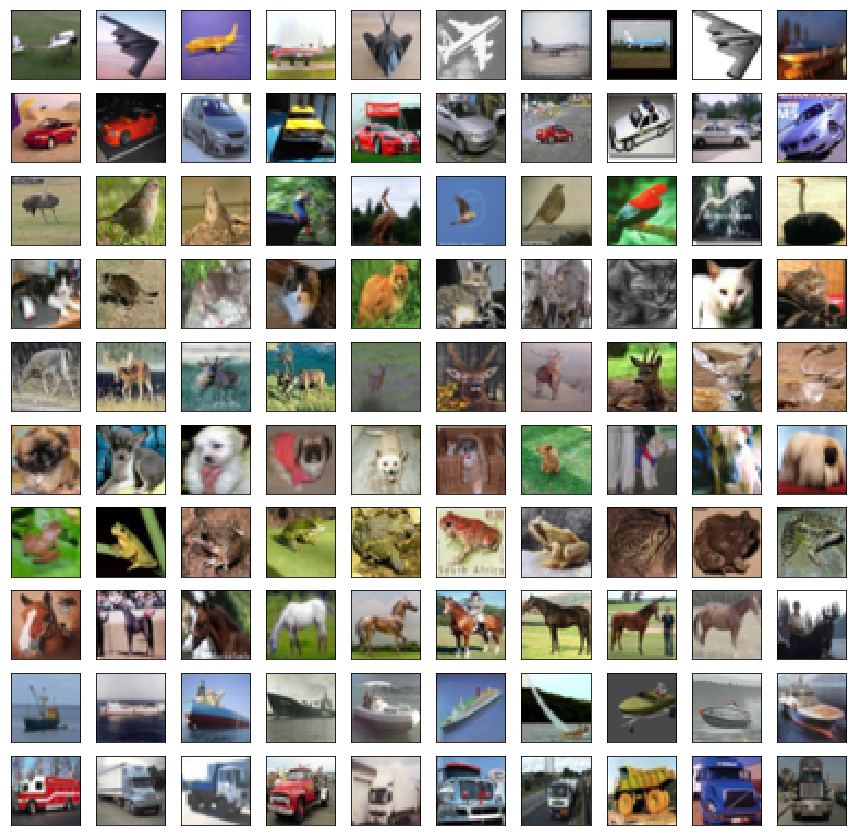

In [145]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

random_indices = []
for idx in range(10):
    random_indices += list(np.random.choice(np.where(np.array(y_train)==idx)[0], size=10))

fig = plt.figure(figsize=(15,15))
for i, ridx in enumerate(random_indices):
    ax = fig.add_subplot(10,10,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    tmp_picture = X_train[ridx,...]
    ax.imshow(tmp_picture)
    
plt.show()

## Shallow classifier - Histogram of Gradient

Histogram of gradient is used to compute features of pictures.

Default parameters for HOGDescriptor are used, only winSize is changed to match size of cifar images.

In [57]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [58]:
train_descriptors = np.zeros((X_train.shape[0], 324))

for idx, img in enumerate(X_train):
    descriptor = hog.compute(img)
    train_descriptors[idx,:] = descriptor.ravel()

In [60]:

test_descriptors = np.zeros((X_test.shape[0], 324))

for idx, img in enumerate(X_test):
    descriptor = hog.compute(img)
    test_descriptors[idx,:] = descriptor.ravel()

###  Fit  Supporting Vector Classifier

C parameter is picked to maximize accuracy of Supporting Vector Classifier on the test set.

In [115]:
def plot_clasifier_accuracy(train_data, test_data, y_train, Cs, kernel='linear'):
    ACCs = np.zeros(len(Cs))
    for idx, C in enumerate(Cs):
        if kernel == 'linear':
            classifier = svm.LinearSVC(C=C)
        else:
            classifier = svm.SVC(C=C, kernel=kernel)
        classifier.fit(train_data, y_train)

        predictions = classifier.predict(test_data)
        ACCs[idx] = np.mean(predictions == np.array(y_test))

    plt.plot(Cs, ACCs)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.title('Hyperparameter search')
    plt.grid(True)
    
    argmax = np.argmax(ACCs)
    print("Maximum for C={}".format(Cs[argmax]))

Maximum for C=0.1


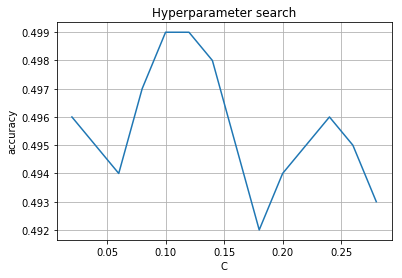

In [107]:
Cs = np.arange(0.02, 0.3, 0.02)
plot_clasifier_accuracy(train_descriptors, test_descriptors, y_train, Cs)

In [250]:
shallow_classifier = svm.LinearSVC(C=0.1)
shallow_classifier.fit(train_descriptors, y_train)
shallow_predictions = shallow_classifier.predict(test_descriptors)
print("Linear SV classifier accuracy for descriptors: {}".format(np.mean(shallow_predictions == np.array(y_test))))

Linear SV classifier accuracy for descriptors: 0.499


## Pre-trained Convolutional Neural Network 

#### VGG16 model

Pre-trained VGG16 model is loaded wih `keras`. Model was trained on the imagnet dataset.

VGG is convolutional neural network. It consits of 22 layers, the three final layers are fully connected.

I will use output of the second fully connected layer `fc2` to compute CNN codes.

In [63]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')

In [64]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [255]:
len(vgg_model.layers)

22

### Preprocessing

Images need to be upscaled to 224x224 pixels. 

The mean for each color channel needs to be subtracted. The mean was calculated for imagenet dataset. 

Additionally RGB channels need to be changed to BGR.

The preprocessing is needed to be consistent with original dataset (imagnet).

In [ ]:
def preprocess_vgg(data):
    VGG_MEAN = np.array([103.94, 116.78, 123.68])
    out_data = np.zeros((data.shape[0],224,224,3))
    for idx, img in  enumerate(data):
        out_data[idx,...] = resize(img, (224,224), preserve_range=True)

    out_data = out_data[:,:,:,::-1]
    out_data -= VGG_MEAN
    
    return out_data

In [245]:
X_train_vgg = preprocess_vgg(X_train)

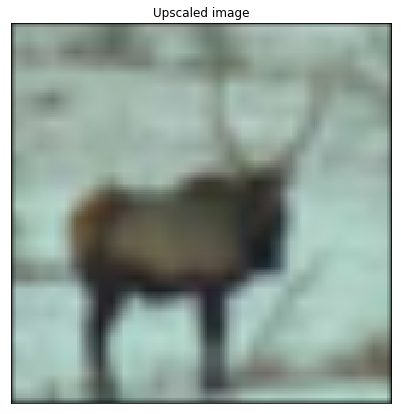

In [246]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(resize(X_train[0], (224,224), preserve_range=True).astype('int'))

ax.set_title("Upscaled image")

fig.show()

NOTICE THAT: Execution of the following block takes a lot of time. CNN codes may be loaded from a file.

In [67]:
vgg_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer('fc2').output)
vgg_train= vgg_model.predict(X_train_vgg)

In [247]:
X_test_vgg = preprocess_vgg(X_test)

NOTICE THAT: Execution of the following block takes a lot of time. CNN codes may be loaded from a file.

In [89]:
vgg_test = vgg_model.predict(X_test_vgg)

### CNN codes visualization

To visualize CNN codes dimensionality was reduced to 2. PCA and TSNE were used.

We observe that in TSNE visualization, classes are more distinct.

In [101]:
vgg_train_pca = decomposition.PCA(n_components=2).fit_transform(vgg_train)
vgg_train_tsne  = TSNE(n_components=2).fit_transform(vgg_train)

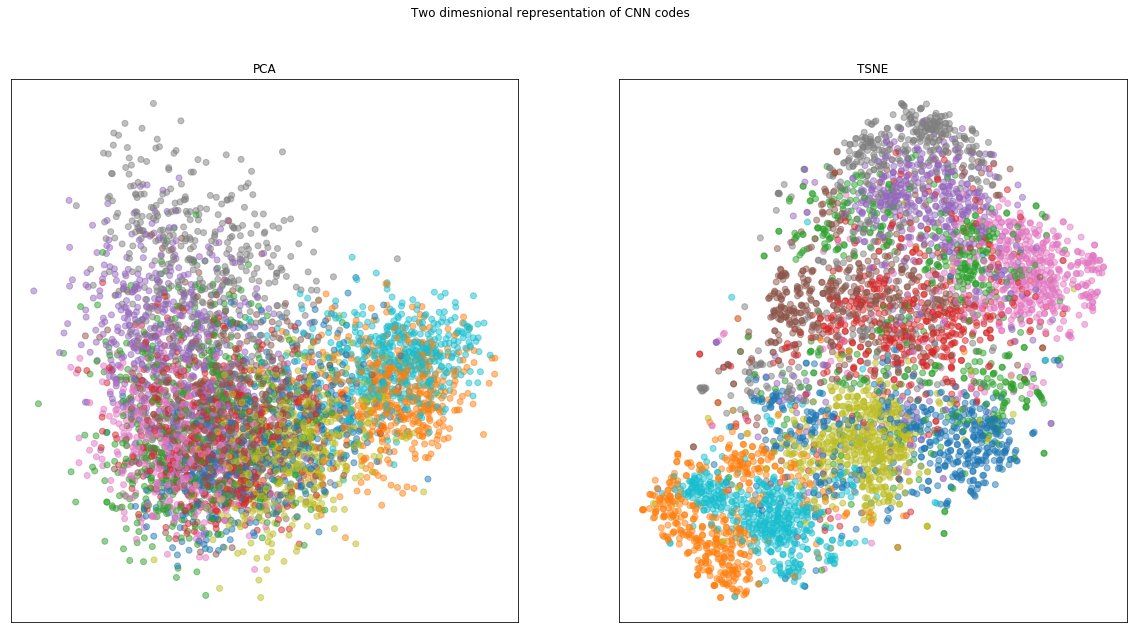

In [140]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = axs[0]
ax.scatter(vgg_train_pca[:,0], vgg_train_pca[:,1], alpha=0.5, c=y_train, cmap='tab10')
ax.set_title('PCA')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
ax.scatter(vgg_train_tsne[:,0], vgg_train_tsne[:,1], alpha=0.5, c=y_train, cmap='tab10')
ax.set_title('TSNE')
ax.set_xticks([])
ax.set_yticks([])


fig.suptitle('Two dimesnional representation of CNN codes')

plt.show()

### Fit SV Clasifier for CNN codes

Maximum for C=0.002


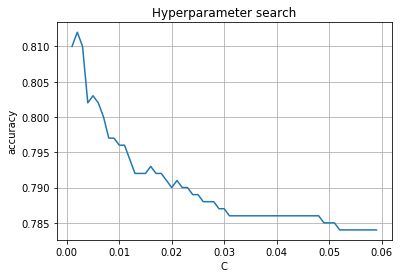

In [93]:
Cs = np.arange(0.001, 0.06, 0.001)
plot_clasifier_accuracy(vgg_train, vgg_test, y_train, Cs)

In [251]:
vgg_classifier = svm.LinearSVC(C=0.002)
vgg_classifier.fit(vgg_train, y_train)
vgg_predictions = vgg_classifier.predict(vgg_test)
print("Linear SV classifier accuracy: {}".format(np.mean(vgg_predictions == np.array(y_test))))

Linear SV classifier accuracy: 0.812


Maximum for C=0.9999999999999999


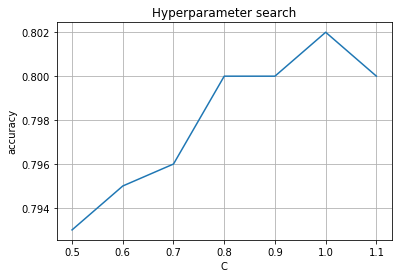

In [116]:
Cs = np.arange(0.5, 1.2, 0.1)
plot_clasifier_accuracy(vgg_train, vgg_test, y_train, Cs, kernel='rbf')

In [252]:
vgg_classifier2 = svm.SVC(kernel='rbf')
vgg_classifier2.fit(vgg_train, y_train)
vgg_predictions2 = vgg_classifier2.predict(vgg_test)
np.mean(vgg_predictions2 == np.array(y_test))
print("Gaussian kernel SV classifier accuracy: {}".format(np.mean(vgg_predictions2 == np.array(y_test))))

Gaussian kernel SV classifier accuracy: 0.802


### Save CNN codes

Codes were saved. It allows to skip time-consuming computation.

In [109]:
file_path = "VGG_train.json"
jsonable = vgg_train.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

file_path = "VGG_test.json"
jsonable = vgg_test.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [111]:
file_path = "VGG_train.json"
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
vgg_train = json.loads(obj_text)
vgg_train = np.array(vgg_train)

file_path = "VGG_test.json"
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
vgg_test = json.loads(obj_text)
vgg_test = np.array(vgg_test)

### Summary

The best SV Classifier traind on CNN codes achieved accuracy **81.2%**. It is much higher than 49.9% for shallow classifier.

The most severe constraint was computational power. To cope with it only 10% of CIFAR10 dataset was used.

VGG16 architecture was picked. It has more trainable parameters than InceptionV3, yet most of its parameters are in last three fully connected layer. Therfore computation of CNN codes is faster.

#### Key drawbacks of the approach:

* Small dataset (only 10% of original CIFAR10)
* Preprocessing, images needed to be upscaled 7 times for each dimesnion. It makes images blurry.
* Neural network was trained on different dataset with different classes. Especially fully connected layers are optimized to distinguish original classes.
* In the original approach softmax loss was used for optimization. In this approach SVM classification is used on top of CNN codes.



## Bagging classifiers

In the following steps bagging classifiers were build.

They combine 10 instances of SV classifiers. Each instance is fitted on the randomly chosen half of the features.


In [211]:
bagging_shallow_clasifier = BaggingClassifier(svm.LinearSVC(C=0.1), max_samples=1.0, max_features=0.5)
bagging_vgg_clasifier = BaggingClassifier(svm.LinearSVC(C=0.002), max_samples=1.0, max_features=0.5)
bagging_vgg_clasifier2 = BaggingClassifier(svm.SVC(C=1.,kernel='rbf'), max_samples=1.0, max_features=0.5)

In [215]:
bagging_shallow_clasifier.fit(train_descriptors, y_train)
b_shallow_predictions =  bagging_shallow_clasifier.predict(test_descriptors)

np.mean(b_shallow_predictions == np.array(y_test))

0.512

In [212]:
bagging_vgg_clasifier.fit(vgg_train, y_train)
b_vgg_predictions =  bagging_vgg_clasifier.predict(vgg_test)

np.mean(b_vgg_predictions == np.array(y_test))

0.807

In [213]:
bagging_vgg_clasifier2.fit(vgg_train, y_train)
b_vgg_predictions2 =  bagging_vgg_clasifier2.predict(vgg_test)

np.mean(b_vgg_predictions2 == np.array(y_test))

0.794

Bagging clasifiers give similar results to base classifiers. Better for shallow classifier (+1.3%) and worse for CNN codes clasifiers (-0.5%, -0.8%).

### Combined clasifier
When probabilities of all three bagging classifiers are averaged we can achieve the best accuracy: **81.4%**.

In [254]:
combined_probs = (bagging_shallow_clasifier.predict_proba(test_descriptors) +
                 bagging_vgg_clasifier.predict_proba(vgg_test) +
                 bagging_vgg_clasifier2.predict_proba(vgg_test))/3

combined_predictions = np.argmax(combined_probs, axis=1)
print("Combined classifier accuracy: {}".format(np.mean(combined_predictions == np.array(y_test))))

Combined classifier accuracy: 0.814
